# Cleaning & Understanding Data

In [18]:
import config
import csv
import pandas as pd
import numpy as np
from collections import Counter
import requests
import mysql.connector
from mysql.connector import errorcode
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import scipy.stats
sns.set()

In [2]:
df = pd.read_csv('Index_Crimes_by_County_and_Agency__Beginning_1990.csv')

In [3]:
counties = ['Kings', 'Bronx', 'New York', 'Queens', 'Erie', 'Suffolk', 'Westchester', 'Nassau', 'Monroe', 'Onondaga']

def create_new_df(list_of_counties):
  counties = []
  for county in list_of_counties:
    county_lower = county.lower
    county_lower = pd.DataFrame(df[(df['Agency']=='County Total') & (df['County']==county)].sort_values('Year'))
    counties.append(county_lower)
  return counties


In [4]:
counties_df = create_new_df(counties)

In [5]:
counties_df

Kings
Bronx
New York
Queens
Erie
Suffolk
Westchester
Nassau
Monroe
Onondaga
CPU times: user 51.2 ms, sys: 6.29 ms, total: 57.5 ms
Wall time: 67.5 ms


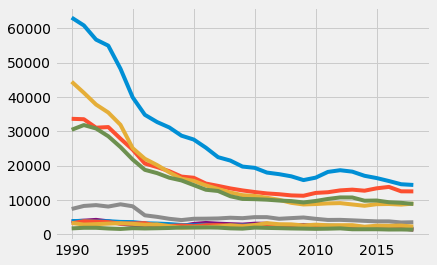

In [5]:
%%time
plt.style.use("fivethirtyeight")

for county in counties_df:
  year_total = county['Year']
  index_total = county['Violent Total']
  plt.plot(year_total, index_total)
  print(county['County'].head(1).to_string()[5:].strip())


# Calling Census.gov's API for Median Income by State

In [6]:
state = {'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR',
         'California': 'CA','Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE',
         'District of Columbia': 'DC','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI',
         'Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA',
         'Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA','Maine': 'ME',
         'Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
         'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE',
         'Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM',
         'New York': 'NY','North Carolina': 'NC','North Dakota': 'ND','Ohio': 'OH',
         'Oklahoma': 'OK','Oregon': 'OR','Pennsylvania': 'PA','Puerto Rico': 'PR','Rhode Island': 'RI',
         'South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX',
         'Utah': 'UT','Vermont': 'VT','Virginia': 'VA','Washington': 'WA',
         'West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'}

median_income = "DP03_0062E"

def get_list_of_tuples_from_api_census(variable_name, year):
    parameters = {
        "get": f"NAME,{variable_name}",
        "for": "state:*",
        "key": config.census_api_key
    }

    response = requests.get(f"http://api.census.gov/data/{year}/acs/acs1/profile", params=parameters)

    json_response = response.json()

    df = pd.DataFrame(json_response)
    df.columns = df.iloc[0]
    df = df.iloc[1:].reset_index()
    df = df.drop(['index'], axis=1)
    df['abbrev'] = df['NAME'].map(state)
    df['year']=year
    df['PK']=df['abbrev']+df['year'].map(str)
    df = df[['NAME', 'abbrev', 'DP03_0062E', 'year', 'PK']].sort_values(by=['abbrev'])

    list_of_tuples = []
    for index, row in df.iterrows():
        list_of_tuples.append((row['NAME'], row['abbrev'], row[f'{variable_name}'], row['year'], row['PK']))
        
    return list_of_tuples


In [7]:
years = [*range(2010,2019)]

census_median_income_data = []
for year in years:
    census_median_income_data.append(get_list_of_tuples_from_api_census(median_income, year))

In [26]:
census_median_income_data

# Calling Census.gov's API for Median Income by NY County

In [8]:
median_income = "DP03_0062E"
def get_list_of_tuples_from_api_census_ny_county(variable_name, year):
    parameters = {
        "get": f"NAME,{variable_name}",
        "for": "county:*",
        "in" : "state:36",
        "key": config.census_api_key
    }

    response = requests.get(f"http://api.census.gov/data/{year}/acs/acs1/profile", params=parameters)

    json_response = response.json()

    df = pd.DataFrame(json_response)
    df.columns = df.iloc[0]
    df = df.iloc[1:].reset_index()
    df = df.drop(['index'], axis=1)
    df['year']=year
    df['NAME'] = df['NAME'].str[:-17]
    df['PK'] = df['NAME'].str.lower() + df['year'].map(str)
    df = df[['NAME', variable_name, 'year', 'PK']].sort_values(by=['NAME'])

    list_of_tuples = []
    for index, row in df.iterrows():
        list_of_tuples.append((row['NAME'], row[f'{variable_name}'], row['year'], row['PK']))

    return list_of_tuples

In [9]:
years = [*range(2010,2019)]

census_median_income_data_ny_county = []
for year in years:
    census_median_income_data_ny_county.append(get_list_of_tuples_from_api_census_ny_county(median_income, year))

In [15]:
census_median_income_data_ny_county

# Convert CSV file for NY Gov Violent Crimes

In [10]:
counties = ['Kings', 'Bronx', 'New York', 'Queens', 'Erie', 'Suffolk', 'Westchester', 'Nassau', 'Monroe', 'Onondaga']

def create_new_df(list_of_counties):
    
    counties = []
    for county in list_of_counties:
        county_lower = county.lower
        county_lower = pd.DataFrame(df[(df['Agency']=='County Total') & (df['County']==county)].sort_values('Year'))
        county_lower['PK'] = df['County'].str.lower() + df['Year'].map(str)
        county_lower['Violent Total'] = df['Violent Total'].fillna(0).astype(int)
        counties.append(county_lower)

    list_of_tuples = []
    for item in counties:
        for index, row in item.iterrows():
            list_of_tuples.append((row['County'], row['Violent Total'], row['Year'], row['PK']))

    return list_of_tuples

counties_df = create_new_df(counties)

In [22]:
counties_df

# Create Database

In [6]:
db_name = config.db_name

In [7]:
cnx = mysql.connector.connect(
    host=config.host,
    user=config.user,
    passwd=config.password,
    database=db_name,
    buffered=True
)

cursor = cnx.cursor()

In [13]:
def create_database(cursor, database):
    try:
        cursor.execute(
            "CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(database))
    except mysql.connector.Error as err:
        print("Failed creating database: {}".format(err))
        exit(1)
        
#run create_database
try:
    cursor.execute("USE {}".format(db_name))
except mysql.connector.Error as err:
    print("Database {} does not exists.".format(db_name))
    if err.errno == errorcode.ER_BAD_DB_ERROR:
        create_database(cursor, db_name)
        print("Database {} created successfully.".format(db_name))
        cnx.database = db_name
    else:
        print(err)
        exit(1)

# Create DB Tables

In [12]:
TABLES = {}
TABLES['census_med_inc_state'] = (
    """CREATE TABLE census_med_inc_state (
       state_name varchar(50) NOT NULL,
       state_abbrev varchar(10) NOT NULL,
       med_inc int(10) NOT NULL,
       year int(10) NOT NULL,
       pk varchar(10) NOT NULL,
       PRIMARY KEY (pk)
     ) ENGINE=InnoDB;""")

TABLES['census_med_inc_county'] = (
    """CREATE TABLE census_med_inc_county (
       county_name varchar(50) NOT NULL,
       med_inc int(10) NOT NULL,
       year int(10) NOT NULL,
       pk varchar(50) NOT NULL,
       PRIMARY KEY (pk)
     ) ENGINE=InnoDB;""")

TABLES['ny_state_violent_crimes_total'] = (
    """CREATE TABLE ny_state_violent_crimes_total (
       county_name varchar(50) NOT NULL,
       violent_total int(10) NOT NULL,
       year int(10) NOT NULL,
       pk varchar(50) NOT NULL,
       PRIMARY KEY (pk)
     ) ENGINE=InnoDB;""")

TABLES['fbi_crime_data'] = (
     """CREATE TABLE fbi_crime_data (
        year_state_key VARCHAR(10) NOT NULL PRIMARY KEY,
        state VARCHAR(10) NOT NULL,
        year int(10) NOT NULL,
        population int(10) NOT NULL,
        violent_crimes_count INT(10) NOT NULL
    ) ENGINE=InnoDB;""")


In [13]:
for table_name in TABLES:
    table_description = TABLES[table_name]
    try:
        print("Creating table {}: ".format(table_name), end='')
        cursor.execute(table_description)
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_TABLE_EXISTS_ERROR:
            print("already exists.")
        else:
            print(err.msg)
    else:
        print("OK")


Creating table census_med_inc_state: already exists.
Creating table census_med_inc_county: already exists.
Creating table ny_state_violent_crimes_total: already exists.
Creating table fbi_crime_data: OK


# Insert tuples into `census_med_inc_state` db table

In [16]:
db_table = 'census_med_inc_state'
for year in census_median_income_data:
    insert_statement = f"""INSERT INTO census_med_inc_state 
                        (state_name, state_abbrev, med_inc, year, pk) 
                        VALUES (%s, %s, %s, %s, %s)"""
    cursor.executemany(
        insert_statement, year)
    cnx.commit()
    print(
        f"Successfully added to database: '{db_name}' on table: '{db_table}' for year: '{year[0][3]}'")

Successfully added to database: 'mod3_eda' on table: 'census_med_inc_state' for year: '2010'
Successfully added to database: 'mod3_eda' on table: 'census_med_inc_state' for year: '2011'
Successfully added to database: 'mod3_eda' on table: 'census_med_inc_state' for year: '2012'
Successfully added to database: 'mod3_eda' on table: 'census_med_inc_state' for year: '2013'
Successfully added to database: 'mod3_eda' on table: 'census_med_inc_state' for year: '2014'
Successfully added to database: 'mod3_eda' on table: 'census_med_inc_state' for year: '2015'
Successfully added to database: 'mod3_eda' on table: 'census_med_inc_state' for year: '2016'
Successfully added to database: 'mod3_eda' on table: 'census_med_inc_state' for year: '2017'
Successfully added to database: 'mod3_eda' on table: 'census_med_inc_state' for year: '2018'


# Insert tuples into `census_med_inc_state` db table

In [18]:
db_table = 'census_med_inc_county'
for year in census_median_income_data_ny_county:
    insert_statement = f"""INSERT INTO census_med_inc_county 
                        (county_name, med_inc, year, pk) 
                        VALUES (%s, %s, %s, %s)"""
    cursor.executemany(
        insert_statement, year)
    cnx.commit()
    print(
        f"Successfully added to database: '{db_name}' on table: '{db_table}' for year: '{year[0][2]}'")


Successfully added to database: 'mod3_eda' on table: 'census_med_inc_county' for year: '2010'
Successfully added to database: 'mod3_eda' on table: 'census_med_inc_county' for year: '2011'
Successfully added to database: 'mod3_eda' on table: 'census_med_inc_county' for year: '2012'
Successfully added to database: 'mod3_eda' on table: 'census_med_inc_county' for year: '2013'
Successfully added to database: 'mod3_eda' on table: 'census_med_inc_county' for year: '2014'
Successfully added to database: 'mod3_eda' on table: 'census_med_inc_county' for year: '2015'
Successfully added to database: 'mod3_eda' on table: 'census_med_inc_county' for year: '2016'
Successfully added to database: 'mod3_eda' on table: 'census_med_inc_county' for year: '2017'
Successfully added to database: 'mod3_eda' on table: 'census_med_inc_county' for year: '2018'


# Insert tuples into `ny_state_violent_crimes_total` db table

In [19]:
db_table = 'ny_state_violent_crimes_total'
insert_statement = f"""INSERT INTO ny_state_violent_crimes_total 
                    (county_name, violent_total, year, pk) 
                    VALUES (%s, %s, %s, %s)"""
cursor.executemany(
    insert_statement, counties_df)
cnx.commit()
print(
    f"Successfully added to database: '{db_name}' on table: '{db_table}' for year: '{year[0][2]}'")

Successfully added to database: 'mod3_eda' on table: 'ny_state_violent_crimes_total' for year: '2018'


# Analysis 1 H0 = Prison Population Does Not Affect Median Income

In [8]:
execute_statement = """
                    SELECT ce.state_abbrev, pr.prison_population_count, ce.med_inc, ce.year
                    FROM mod3_eda.census_med_inc_state AS ce
                    INNER JOIN mod3_eda.prison_population_data AS pr
                    ON ce.pk = pr.year_state_key
                    ;
                    """
cursor.execute(execute_statement)
h0_2 = cursor.fetchall()

column = ['state', 'prison_population', 'median_income', 'year']
h0_2_df = pd.DataFrame(h0_2, columns = column)

df_ny = h0_2_df[h0_2_df['state']=='NY']
df_ca = h0_2_df[h0_2_df['state']=='CA']
df_md = h0_2_df[h0_2_df['state']=='MD']
df_tx = h0_2_df[h0_2_df['state']=='TX']

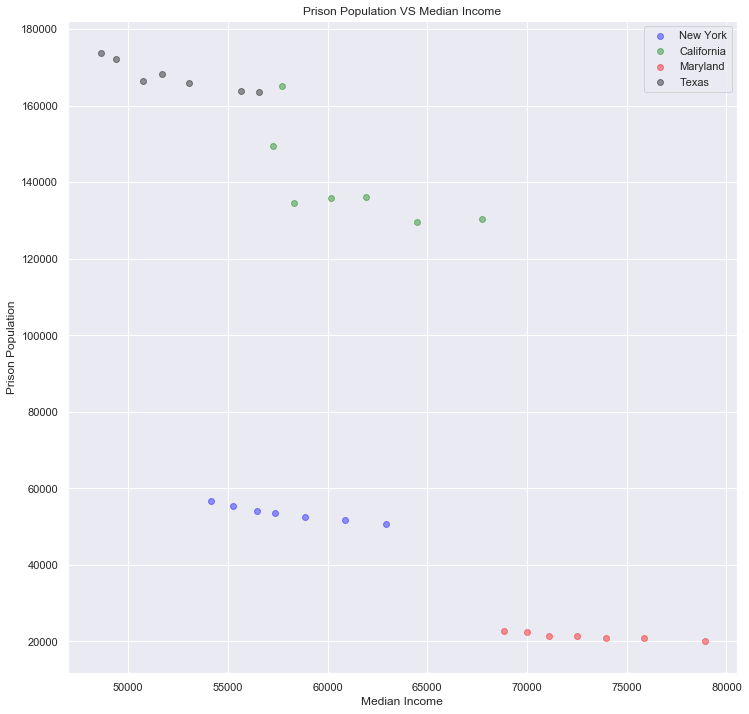

In [29]:
font = {'size' : 18}
plt.figure(figsize = (12, 12))

# plot = plt.scatter(x = 'median_income', y = 'prison_population', alpha = 0.4, c = 'orange', data = h0_2_df)
plot = plt.scatter(x = 'median_income', y = 'prison_population', alpha = 0.4, c = 'blue', data = df_ny, label = 'New York')
plot = plt.scatter(x = 'median_income', y = 'prison_population', alpha = 0.4, c = 'green', data = df_ca, label = 'California')
plot = plt.scatter(x = 'median_income', y = 'prison_population', alpha = 0.4, c = 'red', data = df_md, label = 'Maryland')
plot = plt.scatter(x = 'median_income', y = 'prison_population', alpha = 0.4, c = 'black', data = df_tx, label = 'Texas')
plt.xlabel('Median Income')
plt.ylabel('Prison Population')
plt.title('Prison Population VS Median Income')
plt.legend()
plt.show()

In [30]:
ny_pc = scipy.stats.pearsonr(df_ny['median_income'], df_ny['prison_population'])
print(f"Pearson's Correlation for NY {ny_pc}")

ca_pc = scipy.stats.pearsonr(df_ca['median_income'], df_ca['prison_population'])
print(f"Pearson's Correlation for CA {ca_pc}")

md_pc = scipy.stats.pearsonr(df_md['median_income'], df_md['prison_population'])
print(f"Pearson's Correlation for MD {md_pc}")

tx_pc = scipy.stats.pearsonr(df_tx['median_income'], df_tx['prison_population'])
print(f"Pearson's Correlation for TX {tx_pc}")

all_state_pc = scipy.stats.pearsonr(h0_2_df['median_income'], h0_2_df['prison_population'])
print(f"Pearson's Correlation for All Counties {all_state_pc}")

Pearson's Correlation for NY (-0.9806660369479228, 9.879681683570108e-05)
Pearson's Correlation for CA (-0.6868176597339364, 0.0882885554768823)
Pearson's Correlation for MD (-0.9631819555149908, 0.0004897623357986304)
Pearson's Correlation for TX (-0.9107266024179015, 0.004356785826686513)
Pearson's Correlation for All Counties (-0.09598371021522997, 0.07008161537459877)


# Analysis 2 H0 = Violent Crime Is Not Affected By Median Income

In [20]:
execute_statement = """
                    SELECT ny.county_name, violent_total, med_inc, ny.year
                    FROM mod3_eda.ny_state_violent_crimes_total AS ny
                    INNER JOIN mod3_eda.census_med_inc_county AS ce 
                    ON ny.pk = ce.pk
                    ;
                    """

cursor.execute(execute_statement)
ny_counties = cursor.fetchall()

column = ['county', 'violent_total', 'median_income', 'year']
county_df = pd.DataFrame(ny_counties, columns = column)

df_bronx = county_df[county_df['county']=='Bronx']
df_kings = county_df[county_df['county']=='Kings']
df_nyc = county_df[county_df['county']=='New York']
df_queens = county_df[county_df['county']=='Queens']

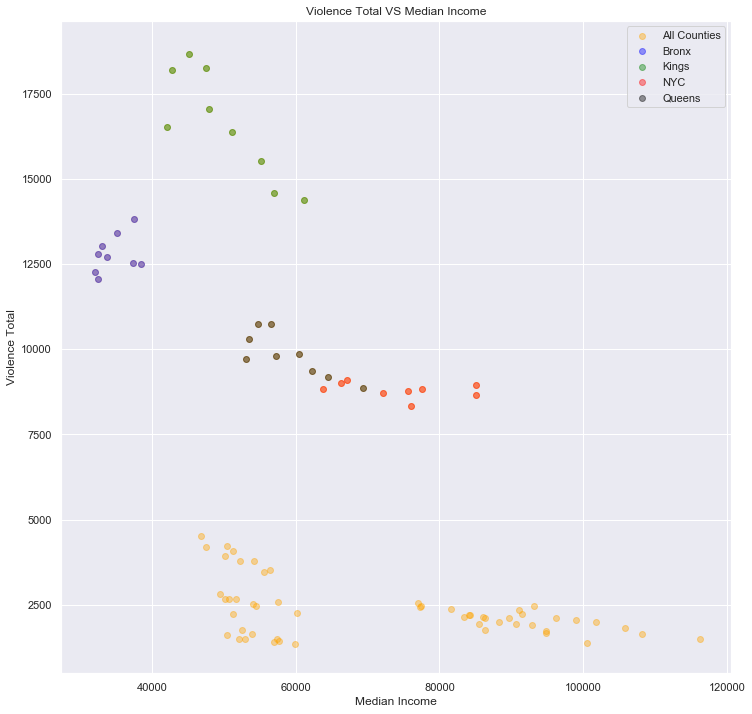

In [27]:
font = {'size' : 18}
matplotlib.rc('font', **font)
plt.figure(figsize = (12, 12))


plot = plt.scatter(x = 'median_income', y = 'violent_total', alpha = 0.4, c = 'orange', data = county_df, label = 'All Counties')
plot = plt.scatter(x = 'median_income', y = 'violent_total', alpha = 0.4, c = 'blue', data = df_bronx, label = 'Bronx')
plot = plt.scatter(x = 'median_income', y = 'violent_total', alpha = 0.4, c = 'green', data = df_kings, label = 'Kings')
plot = plt.scatter(x = 'median_income', y = 'violent_total', alpha = 0.4, c = 'red', data = df_nyc, label = 'NYC')
plot = plt.scatter(x = 'median_income', y = 'violent_total', alpha = 0.4, c = 'black', data = df_queens, label = 'Queens')

plt.xlabel('Median Income')
plt.ylabel('Violence Total')
plt.title('Violence Total VS Median Income')
plt.legend()
plt.show()

In [22]:
kings_pc = scipy.stats.pearsonr(df_kings['median_income'], df_kings['violent_total'])
print(f"Pearson's Correlation for Kings County {kings_pc}")

bronx_pc = scipy.stats.pearsonr(df_kings['median_income'], df_bronx['violent_total'])
print(f"Pearson's Correlation for Bronx County {bronx_pc}")

queens_pc = scipy.stats.pearsonr(df_queens['median_income'], df_queens['violent_total'])
print(f"Pearson's Correlation for Queens County {queens_pc}")

nyc_pc = scipy.stats.pearsonr(df_nyc['median_income'], df_nyc['violent_total'])
print(f"Pearson's Correlation for NYC {nyc_pc}")

all_pc = scipy.stats.pearsonr(county_df['median_income'], county_df['violent_total'])
print(f"Pearson's Correlation for All Counties {all_pc}")

Pearson's Correlation for Kings County (-0.8432480220575884, 0.004292127020089862)
Pearson's Correlation for Bronx County (0.34678484506239937, 0.3605591263030325)
Pearson's Correlation for Queens County (-0.7963334792881761, 0.010220652503883031)
Pearson's Correlation for NYC (-0.32365872507409815, 0.3955274278259911)
Pearson's Correlation for All Counties (-0.5474336893994886, 2.3574535119250243e-08)
